<a href="https://colab.research.google.com/github/ShehryarSohail7/LUMS-Forestfire-Observatory/blob/main/ForestFireSProj/next_day_wildfire/notebooks/ForestFireModelV001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [565]:
# !pip show tensorflow
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
from tensorflow import add
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Dropout, MaxPooling2D, UpSampling2D, Concatenate, Add
from tensorflow.keras.callbacks import ModelCheckpoint

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [566]:
# gpus = tf.config.list_physical_devices("GPU")
# if gpus:
#     for gpu in gpus:
#         print(gpu)
# else:
#     print("No GPUs Found.")

In [567]:
file_pattern = '/content/drive/My Drive/next_day_wildfire/next_day_wildfire_spread_train*'
val_file_pattern = '/content/drive/My Drive/next_day_wildfire/next_day_wildfire_spread_eval*'
test_file_pattern = '/content/drive/My Drive/next_day_wildfire/next_day_wildfire_spread_test*'
# !dir "archive"
# file_pattern = './archive/next_day_wildfire_spread_train*/'
# val_file_pattern = './archive/next_day_wildfire_spread_eval*'
# test_file_pattern = './archive/next_day_wildfire_spread_test*'

In [568]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [569]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    num_in_channels: number of channels in input_img.
    num_out_channels: number of channels in output_img.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Center crops input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

In [570]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [571]:
dataset = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

val_dataset = get_dataset(
      val_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test_dataset = get_dataset(
      test_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)


print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 12), dtype=tf.float32, name=None), TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None))>


In [572]:
inputs, labels = next(iter(dataset))

print(inputs.shape, labels.shape)

(100, 32, 32, 12) (100, 32, 32, 1)


In [573]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

In [574]:
# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.33, 0.33, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

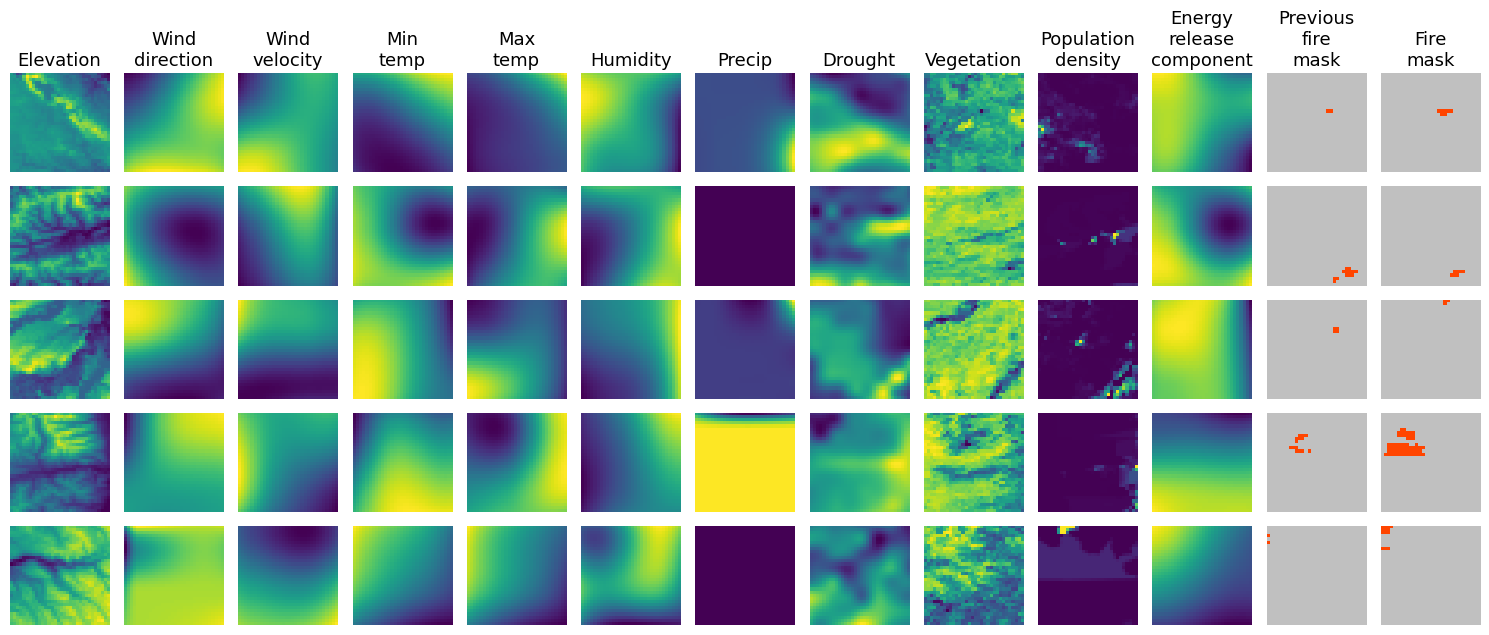

In [575]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)
    plt.axis('off')
plt.tight_layout()

In [576]:
# Function to create Residual Block with Maxpool
def resblock_maxpool(x, filters):
    branch1 = LeakyReLU(alpha=0.2)(x)
    branch1 = Dropout(0.1)(branch1)
    branch1 = MaxPooling2D((2, 2))(branch1)
    branch1 = LeakyReLU(alpha=0.2)(branch1)
    branch1 = Dropout(0.1)(branch1)
    branch1 = Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(branch1)
    branch1 = Dropout(0.1)(branch1)

    branch2 = MaxPooling2D((2, 2))(x)
    branch2 = Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(branch2)
    # branch2 = MaxPooling2D((2, 2))(branch2)
    branch2 = Dropout(0.1)(branch2)

    # merged = add(branch1, branch2)
    merged = Add()([branch1, branch2])
    return merged

# Function to create Residual Block with Conv2D
def resblock_conv2d(x, filters):
    branch1 = LeakyReLU(alpha=0.2)(x)
    branch1 = Dropout(0.1)(branch1)
    branch1 = Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(branch1)
    branch1 = LeakyReLU(alpha=0.2)(branch1)
    branch1 = Dropout(0.1)(branch1)
    branch1 = Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(branch1)
    branch1 = Dropout(0.1)(branch1)

    branch2 = Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(x)
    branch2 = Dropout(0.1)(branch2)
    branch2 = Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(branch2)

    merged = Add()([branch1, branch2])
    # merged = add(branch1, branch2)
    return merged

In [577]:
def autoencoder(input_shape, batch_size=None):
    input_layer = Input(shape=input_shape, batch_size=batch_size)
    print(input_layer.shape)
    # Branch 1
    branch1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(input_layer)
    branch1 = LeakyReLU(alpha=0.2)(branch1)
    branch1 = Dropout(0.1)(branch1)
    branch1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(branch1)

    # Branch 2
    branch2 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(input_layer)
    branch2 = Dropout(0.1)(branch2)
    # Merge both branches
    merged = Add()([branch1, branch2])
    # Residual blocks with Maxpool
    for i in range(2):
        merged = resblock_maxpool(merged, 32)

    # Upsample
    merged = UpSampling2D((2, 2))(merged)

    # Residual block with Conv2D
    merged = resblock_conv2d(merged, 32)

    # Upsample
    merged = UpSampling2D((2, 2))(merged)

    # Residual block with Conv2D
    merged = resblock_conv2d(merged, 32)

    # Final Conv2D layer
    output_layer = Conv2D(3, (3, 3), strides=(1, 1), padding='same')(merged) # TESTING, MAKE CHANNELS EQUAL TO 1 FOR MSE, MADE IT 3 FOR SPARSE CROSS ENT LOSS

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    return model



In [578]:
input_shape = (32, 32, 12)
batch_size = 100
model = autoencoder(input_shape, batch_size=batch_size)
model.summary()

(100, 32, 32, 12)
Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(100, 32, 32, 12)]          0         []                            
                                                                                                  
 conv2d_416 (Conv2D)         (100, 32, 32, 16)            1744      ['input_27[0][0]']            
                                                                                                  
 leaky_re_lu_234 (LeakyReLU  (100, 32, 32, 16)            0         ['conv2d_416[0][0]']          
 )                                                                                                
                                                                                                  
 dropout_468 (Dropout)       (100, 32, 32, 16)            0         ['lea

In [579]:
print(inputs.shape)
print(model.trainable_variables)

(100, 32, 32, 12)
[<tf.Variable 'conv2d_416/kernel:0' shape=(3, 3, 12, 16) dtype=float32, numpy=
array([[[[-0.0006146 , -0.12220356, -0.0478358 , ...,  0.05717199,
           0.10219349,  0.01817146],
         [-0.02232774, -0.12197882, -0.10735325, ...,  0.1063178 ,
          -0.09036478,  0.00207578],
         [ 0.1458834 , -0.10378923, -0.05088986, ..., -0.10716592,
          -0.10153396, -0.07171305],
         ...,
         [-0.01521091,  0.03512402,  0.13289563, ..., -0.06811874,
          -0.10031213, -0.00261705],
         [-0.14906625, -0.13105108,  0.08205794, ..., -0.09909464,
          -0.05321056,  0.03725696],
         [ 0.02225247, -0.05777506,  0.03267874, ..., -0.05615176,
           0.12782364,  0.1362377 ]],

        [[ 0.13348041, -0.03590306, -0.04409956, ..., -0.1036687 ,
           0.10019301,  0.08165815],
         [-0.01237501, -0.00637358,  0.06915067, ..., -0.13348745,
           0.08902839, -0.01392297],
         [-0.02154447,  0.03071897,  0.0190087 , ...,  

In [580]:
count = 0
for i, data in enumerate(dataset, 0):
  input, labels = data
  count = count + input.shape[0]
print(count)


count = 0
for i, data in enumerate(val_dataset, 0):
  input, labels = data
  count = count + input.shape[0]
  # count = count + 1
print(count)

count = 0
for i, data in enumerate(test_dataset, 0):
  input, labels = data
  count = count + input.shape[0]
  # count = count + 1
print(count)

# def add_one_to_label(features, labels):
#   return features, labels+1

# train_dataset = dataset.map(add_one_to_label) # Remapping -1 to 0 (No Data), 0 to 1 (No Fire), 1 to 2 (Fire)


# inputs, labels = next(iter(dataset))
# inputs2, labels2 = next(iter(train_dataset))

# display(labels[10,:,:])
# display(labels2[10,:,:])

14979
1877
1689


In [581]:
def add_one_to_labels(inputs, labels): # TESTING FOR SPARSE CROSS ENTROPY LOSS
  return inputs, labels+1

dataset = dataset.map(add_one_to_labels)
val_dataset = val_dataset.map(add_one_to_labels)
test_dataset = test_dataset.map(add_one_to_labels)

def preprocess_image_label(image, label):
    # Perform any preprocessing on the image (if needed)
    # image = ...

    # One-hot encode the label
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, depth=3)
    label = tf.squeeze(label, axis=3)

    return image, label

dataset = dataset.map(preprocess_image_label)
val_dataset = val_dataset.map(preprocess_image_label)
test_dataset = test_dataset.map(preprocess_image_label)

count = 0
for i, data in enumerate(val_dataset, 0):
  input, labels = data
  print(np.max(labels[0]), i, "VAL")
  # count = count + 1
print(count)
count = 0
for i, data in enumerate(dataset, 0):
  input, labels = data
  print(labels.shape)
  # print(np.max(labels[0]), i, "TRAIN")
  # print(labels[0][0], "LABEL SMTH") # TESTING
  # count = count + 1
print(count)


1.0 0 VAL
1.0 1 VAL
1.0 2 VAL
1.0 3 VAL
1.0 4 VAL
1.0 5 VAL
1.0 6 VAL
1.0 7 VAL
1.0 8 VAL
1.0 9 VAL
1.0 10 VAL
1.0 11 VAL
1.0 12 VAL
1.0 13 VAL
1.0 14 VAL
1.0 15 VAL
1.0 16 VAL
1.0 17 VAL
1.0 18 VAL
0
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)


In [582]:
def normalize_features(input_tensor, epsilon=1e-8):
  # Calculate mean and variance along the last axis (features)
  mean, variance = tf.nn.moments(input_tensor, axes=-1, keepdims=True)

  # Apply normalization
  normalized_tensor = tf.nn.batch_normalization(
      input_tensor,
      mean,
      variance,
      offset=None,  # You can add an offset if needed
      scale=None,   # You can scale the normalized values if needed
      variance_epsilon=epsilon
  )

  return normalized_tensor

In [583]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # This method is called after each epoch
        print(f"\nEnd of Epoch {epoch + 1}. Training loss: {logs['loss']}, Validation loss: {logs['val_loss']}")

# Example usage:

# Assuming you have a compiled model and training/validation data
# model = ...  # your compiled model
# X_train, y_train = ...  # your training data
# X_val, y_val = ...  # your validation data

# Create an instance of your custom callback

checkpoint_filepath = '/content/drive/My Drive/ffmodel/model_checkpoint.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',  # Choose the validation metric to monitor (e.g., 'val_loss', 'val_accuracy')
    mode='min',  # 'min' if the metric should be minimized, 'max' if it should be maximized
    verbose=1
)

my_callback = MyCallback()

def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1

In [584]:
learning_rate = 0.0001
class_weights = {0: 1, 1: 1, 2: 3}

# criterion = tf.keras.losses.MeanSquaredError()
# criterion = tf.keras.losses.SparseCategoricalCrossentropy()

# def train_epoch(epoch_num):
#   running_loss = 0.0

#   for i, data in enumerate(dataset, 0):
#     inputs, labels = data
#     # print(i)
#     inputs = normalize_features(inputs)

#     with tf.GradientTape() as tape:
#       # print(inputs[0][:,:,-1])
#       # print(inputs[0])
#       outputs = model(inputs)
#       # print(outputs[0])
#       # print("OUTPUT", outputs[0])
#       # print("LABEL", labels[0])
#       # print(labels[0])
#       # print(outputs[0])
#       loss = criterion(labels, outputs)
#       # print(loss.numpy())

#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#     running_loss += loss.numpy()

#   avg_loss = running_loss/count
#   # print("AVERAGE LOSS:", avg_loss)
#   return avg_loss
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()]) # CATEGORICAL CROSS ENTROPY OR SPARSE CATEGORICAL CROSS ENTROPY?



def train_model_with_batches(model, train_batches, val_batches=None, epochs=10, class_weights=None):
    """
    Train a TensorFlow model with mini-batches.

    Parameters:
    - model: The TensorFlow model to be trained.
    - train_batches: An iterable providing training mini-batches. Each batch should be a tuple (X_batch, y_batch).
    - val_batches: An iterable providing validation mini-batches. Each batch should be a tuple (X_batch, y_batch).
    - epochs: Number of training epochs.
    - class_weights: Dictionary of class weights for imbalance handling.

    Returns:
    - history: Training history.
    """

    # Compile the model if not already compiled
    if not model.optimizer:
        raise ValueError("The model must be compiled before training.")

    # Train the model
    history = model.fit(
        train_batches,
        epochs=epochs,
        validation_data=val_batches,
        class_weight=class_weights,
        callbacks=[my_callback, model_checkpoint_callback]
    )

    return history

# Example usage:

# Assuming you have a compiled model and training/validation mini-batches
# model = ...  # your compiled model
# train_batches = ...  # iterable providing training mini-batches
# val_batches = ...  # iterable providing validation mini-batches

# Train the model
history = train_model_with_batches(model, train_batches=dataset, val_batches=val_dataset, epochs=1000, class_weights=class_weights) # TESTING CHANGE TO 1000 EPOCHS LATER


Epoch 1/1000
    149/Unknown - 8s 19ms/step - loss: 3.2112 - auc_8: 0.3534
End of Epoch 1. Training loss: 3.2118778228759766, Validation loss: 2.1552629470825195

Epoch 1: val_loss improved from inf to 2.15526, saving model to /content/drive/My Drive/ffmodel/model_checkpoint.keras
150/150 [==============================] - 9s 26ms/step - loss: 3.2119 - auc_8: 0.3528 - val_loss: 2.1553 - val_auc_8: 0.2772
Epoch 2/1000
148/150 [============================>.] - ETA: 0s - loss: 4.1382 - auc_8: 0.4390
End of Epoch 2. Training loss: 4.104855060577393, Validation loss: 1.0048937797546387

Epoch 2: val_loss improved from 2.15526 to 1.00489, saving model to /content/drive/My Drive/ffmodel/model_checkpoint.keras
150/150 [==============================] - 4s 26ms/step - loss: 4.1049 - auc_8: 0.4420 - val_loss: 1.0049 - val_auc_8: 0.7279
Epoch 3/1000
149/150 [============================>.] - ETA: 0s - loss: 3.8426 - auc_8: 0.7166
End of Epoch 3. Training loss: 3.874227523803711, Validation loss:

KeyboardInterrupt: 

In [ ]:
# epochs = 100
# TRAIN_LOSS = []
# # print("TRAIN", model.trainable_variables)
# for epoch in range(epochs):
#   print("INITIALIZING EPOCH {}".format(epoch+1))
#   # Train Epoch
#   tf.keras.backend.set_learning_phase(1)  # Set to training mode
#   epoch_loss = train_epoch(epoch + 1)

#   # Set to evaluation mode
#   tf.keras.backend.set_learning_phase(0)
#   TRAIN_LOSS.append(epoch_loss)
#   print("LOSS TRAIN:", epoch_loss)

In [ ]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask',
  'Predicted\nfire\nmask'
]

In [ ]:
# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
PF_BOUNDS = [-1, -0.1, 0.01, 1] # TESTING
BOUNDS = [0, 0.9, 1.01, 2]
PF_NORM = colors.BoundaryNorm(PF_BOUNDS, CMAP.N)
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

In [ ]:
# LOADING MODEL
model = tf.keras.models.load_model('/content/drive/My Drive/ffmodel/model_checkpoint.keras')

In [ ]:
inputs, labels = next(iter(dataset))
# inputs_ = normalize_features(inputs) # TESTING WITHOUT NORMALIZATION
outputs = model(inputs)
print(outputs[0].shape)
outputs = tf.argmax(outputs, axis=3)
print(outputs[0].shape)
print(np.max(outputs[0]))
print(outputs.shape)
outputs = tf.expand_dims(outputs, axis=-1)
print(outputs.shape)

In [ ]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 2):
    plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=PF_NORM)
    if j == n_features:
      plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)
    if j == n_features+1:
      plt.imshow(outputs[i, :, :, 0], cmap=CMAP, norm=NORM)
    plt.axis('off')
plt.tight_layout()

In [ ]:
import numpy as np

predictions_list = []
labels_list = []
inputs_list = []

for inputs, labels in test_dataset:
  batch_predictions = model.predict(inputs)
  predictions_list.append(batch_predictions)
  labels_list.append(labels)
  inputs_list.append(inputs)

test_predictions = np.concatenate(predictions_list, axis=0)
test_inputs = np.concatenate(inputs_list, axis=0)
test_labels = np.concatenate(labels_list, axis=0)

In [ ]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask',
  'Predicted\nfire\nmask'
]

In [ ]:
print(test_inputs.shape)
print(test_labels.shape)
print(test_predictions.shape)

test_predictions = tf.argmax(test_predictions, axis=3)
test_predictions = tf.expand_dims(test_predictions, axis=-1)
print(test_predictions.shape)

# Number of rows of data samples to plot
n_rows = 50
# Number of data variables
n_features = test_inputs.shape[3]
print(n_features)
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
PF_BOUNDS = [-1, -0.1, 0.01, 1] # TESTING
BOUNDS = [0, 0.9, 1.01, 2]
PF_NORM = colors.BoundaryNorm(PF_BOUNDS, CMAP.N)
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

In [ ]:
test_loss = model.evaluate(test_inputs, test_labels)
print(test_loss)

In [ ]:
fig = plt.figure(figsize=(15,60))

for i in range(n_rows):
  for j in range(n_features + 2):
    plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(test_inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(test_inputs[i, :, :, -1], cmap=CMAP, norm=PF_NORM)
    if j == n_features:
      plt.imshow(test_labels[i, :, :, 0], cmap=CMAP, norm=NORM)
    if j == n_features+1:
      plt.imshow(test_predictions[i, :, :, 0], cmap=CMAP, norm=NORM)
    plt.axis('off')
plt.tight_layout()